# ML-Engineering-with-Azure-Machine-Learning-Serivce
## Train Model Notebook Remote Compute Notebook

The goal of this notebook is to demonstrate leveraging your AML Compute Cluster to train a model that uses the Titantic dataset found on the popular Kaggle website.  https://www.kaggle.com/c/titanic-dataset/data
This dataset is in your Data folder.  Azure Machine learning allows you to train models through scripts leveraging popular machine learning frameworks.  In this notebook, we will leverage sklearn to build a logistic model to predict the survial of a person on the Titantic.  

In this notebook we will leverage the Azure ML SDK to create an experiment for tracing metrics to evaluate the training of our model.

# Connect to your workspace

Let's get started by connecting to the AML workspace leveraging the Azure ML SDK 

In [1]:
import azureml.core
from azureml.core import Workspace
import pandas as pd

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.36.0 to work with mlopsdev


# Explore Dataset

You're going to use a Python script to train a machine learning model based on the Titanic datset found in your data folder.  

In [2]:
df= pd.read_csv('./Data/titanic.csv')
print(df.shape)
print(df.columns)

(891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


## View Data

In [3]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Dataset field information

- **PassengerId**: (remove) Should be removed from model as they are some sort of id.
- **Pclass**: (keep) locates folks on ship *Pclass: 1st = Upper, 2nd = Middle, 3rd = Lower*
- **Name**: (remove) maybe found useful if keeping the surname, but for basic model will remove
- **Sex**: (keep) due to lifeboat priority, will likely be useful
- **Age**: (keep)important due to lifeboat priority
- **SibSp**: (keep) maybe useful, relatives will likely help others
- **Parch**: (keep) maybe useful, relatives will likely help others
- **Ticket**: (remove)
- **Fare**: (remove covered by class)
- **Cabin**: (keep) can be useful in relation of where the cabins are positioned on the ship
- **Embarked**: (keep) unlikely to be useful because all listed embark happened before the disaster

# Data Engineering

## Data Cleansing

We will begin by evaluating the null values in the dataset.  Note that Age, Fare and Cabin contain null values in the dataset.

In [4]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

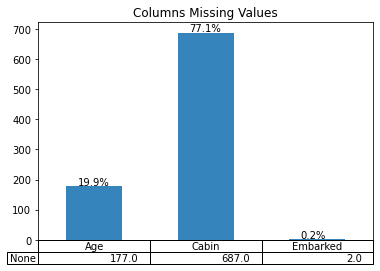

In [5]:
columns_missing = df.isna().sum().where(lambda x : x > 0).dropna()

ax = columns_missing \
.plot(kind='bar', alpha=0.9, title='Columns Missing Values', table=True)
ax.xaxis.set_visible(False) # hide x axis labels

for x in ax.patches:
    ax.text(x.get_x()+.1, x.get_height()+5, \
            str(round((x.get_height()/df.shape[0])*100, 1))+'%')

## Prepare data for an experiment
In the previous notebook, the data was leveraged directly from the folder on the compute instance.  We will be submitting an experiment to a compute cluster, so we will register the dataset so it will be stored in the blob storage associated with the AML workspace

### Stategy:

- For the Age, we will replace the missing values with the medians of each group
- For cabin we will mark it as X given this is probably an important feature that we would want to include.
- For Embarked,given there are only 2 rows missing this value, we will set these to a value of S

## Cleaning Age Column

Note that Age, a column that has missing data, will likely be impacted by class, as people are more established,their age will likely increase, so to replace these values, we will group by class and sex, calculate a median value and replace the na values in the dataset with the mean

In [6]:
display(df.groupby(['Pclass', 'Sex'])['Age'].count())

display(df.groupby(['Pclass', 'Sex'])['Age'].median())

Pclass  Sex   
1       female     85
        male      101
2       female     74
        male       99
3       female    102
        male      253
Name: Age, dtype: int64

Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64

In [7]:
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median()))
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Data Engineering

## Feature Engineering

In [8]:
df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [9]:
df['Loc']= df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'X')

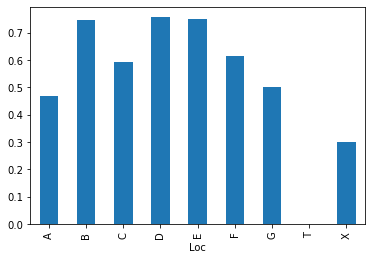

In [10]:
df[['Loc', 'Survived']].groupby('Loc')['Survived'].mean().plot(kind= 'bar')

In [11]:
df.drop(['Cabin', 'Ticket'], axis=1, inplace=True)

In [12]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Loc
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,X
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,X
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,X
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,S,X
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,S,B
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.5,1,2,23.4500,S,X
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C,C


In [13]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
Loc            0
dtype: int64

# Feature Engineering
## Create a Group Size

In [14]:
df.loc[:,'GroupSize'] = 1 + df['SibSp'] + df['Parch']

## Fill Missing Embarded with value of S

In [15]:
df['Embarked'] = df['Embarked'].fillna('S')

In [16]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Loc            0
GroupSize      0
dtype: int64

In [17]:
LABEL = 'Survived'
columns_to_keep = ['Pclass', 'Sex','Age', 'Fare', 'Embared', 'Deck', 'GroupSize']
columns_to_drop = ['Name','SibSp', 'Parch', 'Survived']
df_train = df
df = df_train.drop(['Name','SibSp', 'Parch', 'PassengerId'], axis=1)

df.head(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,Loc,GroupSize
0,0,3,male,22.0,7.2500,S,X,2
1,1,1,female,38.0,71.2833,C,C,2
2,1,3,female,26.0,7.9250,S,X,1
3,1,1,female,35.0,53.1000,S,C,2
4,0,3,male,35.0,8.0500,S,X,1


In [18]:
import os
script_folder = os.path.join(os.getcwd(), "train_remote")
print(script_folder)
os.makedirs(script_folder, exist_ok=True)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/devbox/code/Users/babal/AMLBook2021/AMLBook2022/Chapter3/train_remote


In [19]:
df.to_csv('./train_remote/titanic.csv')
df.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Loc,GroupSize
0,0,3,male,22.0,7.2500,S,X,2
1,1,1,female,38.0,71.2833,C,C,2


In [20]:
from azureml.core import Dataset

#use default datastore retrieved from the workspace through the AML SDK
default_ds = ws.get_default_datastore()


default_ds.upload_files(files=['./train_remote/titanic.csv'], # Upload the diabetes csv files in /data
                        target_path= 'Titanic-data', # Put it in a folder path in the datastore
                        overwrite=True, # Replace existing files of the same name
                        show_progress=True)
#Create a tabular dataset from the path on the datastore 
dataset = Dataset.Tabular.from_delimited_files(default_ds.path('Titanic-data/titanic.csv'))

# Register the dataset
try:
    tab_data_set = dataset.register(workspace=ws, 
                                name= 'Titanic-tabular-dataset',
                                description='Tintanic data',
                                tags = {'format':'csv'},
                                create_new_version=True)
    print('Dataset registered.')
except Exception as ex:
        print(ex)


Uploading an estimated of 1 files
Uploading ./train_remote/titanic.csv
Uploaded ./train_remote/titanic.csv, 1 files out of an estimated total of 1
Uploaded 1 files
Dataset registered.


## Consuming your dataset
Now that the dataset is registered, we can consume it programatically.  
Recall in the Azure ML Workspace on the consume tab the code below is actually provided for you.


In [21]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = 'c46a9435-c957-4e6c-a0f4-b9a597984773'
resource_group = 'mlops'
workspace_name = 'mlopsdev'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='Titanic-tabular-dataset')
dataset.to_pandas_dataframe()

,Column1,Survived,Pclass,Sex,Age,Fare,Embarked,Loc,GroupSize
0,0,0,3,male,22.0,7.2500,S,X,2
1,1,1,1,female,38.0,71.2833,C,C,2
2,2,1,3,female,26.0,7.9250,S,X,1
3,3,1,1,female,35.0,53.1000,S,C,2
4,4,0,3,male,35.0,8.0500,S,X,1
...,...,...,...,...,...,...,...,...,...
886,886,0,2,male,27.0,13.0000,S,X,1
887,887,1,1,female,19.0,30.0000,S,B,1
888,888,0,3,female,21.5,23.4500,S,X,4
889,889,1,1,male,26.0,30.0000,C,C,1


## Train logistic regression model
Create an experiment object in your worksapce. An exeriment will hold the execution of your code and the metrics logged.

In [22]:
from azureml.core.experiment import Experiment
experiment = Experiment(ws, 'titanic_remote_compute')

## Create Training Script

Create a folder to hold your training script.  By running the magic command **%%writefile%%** a file will be generated and placed into the **$script_folder**

In [23]:
import os
script_folder = os.path.join(os.getcwd(), "train")
print(script_folder)
os.makedirs(script_folder, exist_ok=True)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/devbox/code/Users/babal/AMLBook2021/AMLBook2022/Chapter3/train


In [24]:
%%writefile $script_folder/training.py

import os
import sys
import argparse
import joblib
import pandas as pd
import numpy as np

from azureml.core import Run, Dataset, Workspace, Experiment

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score,roc_curve

# Calculate model performance metrics
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

from azureml.core import Model
from azureml.core.resource_configuration import ResourceConfiguration

def getRuntimeArgs():
    parser = argparse.ArgumentParser()
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--input-data", type=str)
    args = parser.parse_args()
    return args

def buildpreprocessorpipeline(X_raw):
    categorical_features = X_raw.select_dtypes(include=['object']).columns
    numeric_features = X_raw.select_dtypes(include=['float','int64']).columns

    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value="missing")),
                                              ('onehotencoder', OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore'))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numeric_transformer, numeric_features),
            ('categorical', categorical_transformer, categorical_features)
        ], remainder="drop")
    
    return preprocessor

def model_train(LABEL, df, run):  
    y_raw = df[LABEL]
    X_raw = df.drop([LABEL], axis=1)
    
     # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.3, random_state=0)
    
    lg = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
    preprocessor = buildpreprocessorpipeline(X_train)
    
    #estimator instance
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', lg)])

    model = clf.fit(X_train, y_train)
    
    
    # calculate AUC
    y_scores = model.predict_proba(X_test)
    auc = roc_auc_score(y_test,y_scores[:,1])
    print('AUC: ' + str(auc))
    run.log('AUC', np.float(auc))

    
    # calculate test accuracy
    y_hat = model.predict(X_test)
    acc = np.average(y_hat == y_test)
    print('Accuracy:', acc)
    run.log('Accuracy', np.float(acc))

    # plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
    fig = plt.figure(figsize=(6, 4))
    # Plot the diagonal 50% line
    plt.plot([0, 1], [0, 1], 'k--')
    # Plot the FPR and TPR achieved by our model
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    run.log_image(name = "ROC", plot = fig)
    plt.show()

    # plot confusion matrix
    # Generate confusion matrix
    cmatrix = confusion_matrix(y_test, y_hat)
    cmatrix_json = {
        "schema_type": "confusion_matrix",
           "schema_version": "v1",
           "data": {
               "class_labels": ["0", "1"],
               "matrix": [
                   [int(x) for x in cmatrix[0]],
                   [int(x) for x in cmatrix[1]]
               ]
           }
    }
    
    run.log_confusion_matrix('ConfusionMatrix_Test', cmatrix_json)

    return model, auc, acc
    # Save the trained model
    
    
def main():
    # Create an Azure ML experiment in your workspace
    args = getRuntimeArgs()
    
    run = Run.get_context()

    dataset_dir = './dataset/'
    os.makedirs(dataset_dir, exist_ok=True)
    ws = run.experiment.workspace
    print(ws)
    

    print("Loading Data...")
    dataset = Dataset.get_by_id(ws, id=args.input_data)
    # Load a TabularDataset & save into pandas DataFrame
    df = dataset.to_pandas_dataframe()
    
    print(df.head(5))
 
    model, auc, acc = model_train('Survived', df, run)
    
    os.makedirs('outputs', exist_ok=True)
    
    
    model_file = os.path.join('outputs', 'titanic_model.pkl')
    joblib.dump(value=model, filename=model_file)
    
    run.upload_file(name='titanic_model.pkl', path_or_stream=model_file)
    
    # Register the model
    print('Registering model...')
    run.register_model(model_path='titanic_model.pkl', model_name= 'titanic-model',
                   tags={'Model Type':'Logistic Regresssion'},
                   properties={'AUC': np.float(auc), 'Accuracy': np.float(acc)})

    run.complete()

if __name__ == "__main__":
    main()

Writing /mnt/batch/tasks/shared/LS_root/mounts/clusters/devbox/code/Users/babal/AMLBook2021/AMLBook2022/Chapter3/train/training.py


## Define an Environment

To run a Python script in an Azure ML experiement, a Conda environment is created.  Azure ML has many environmentsthat include common packages to run an experiment, but you can also define your own using  a Conda specification file.

Use the magic command to create a conda yml file to define your environment for use on your compute cluster

In [25]:
%%writefile $script_folder/experiment_env.yml
name: experiment_env
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2
- scikit-learn
- ipykernel
- matplotlib
- pandas
- pip
- pip:
  - azureml-defaults
  - pyarrow

Writing /mnt/batch/tasks/shared/LS_root/mounts/clusters/devbox/code/Users/babal/AMLBook2021/AMLBook2022/Chapter3/train/experiment_env.yml


Create an environment from the conda specification file

In [26]:
from azureml.core import Environment

# Create a Python environment for the experiment (from a .yml file)
experiment_env = Environment.from_conda_specification('experiment-env', script_folder + "/experiment_env.yml")

# Let Azure ML manage dependencies
experiment_env.python.user_managed_dependencies = False 

# Print the environment details
print(experiment_env.name, 'defined.')
print(experiment_env.python.conda_dependencies.serialize_to_string())

experiment-env defined.
name: experiment_env
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2
- scikit-learn
- ipykernel
- matplotlib
- pandas
- pip
- pip:
  - azureml-defaults
  - pyarrow



## Define script run configuration
To submite a training run, define a ScriptRunConfig for submitting an experiment which should include the following information:

- source_directory : where the script is to run
- script: the python script file to run
- arguments: command line argumentsto pass to a training script
- compute_target: if not specified, the script will run on the local machine, 
    or to run locally specify **compute_target='local'**
- environment: the environment to use when running the script

## Run script on local machine using defined environment

In [27]:
import azureml.core.runconfig
from azureml.core import Environment, Experiment
from azureml.core import ScriptRunConfig
from azureml.widgets import RunDetails

# Get the training dataset
titanic_ds = ws.datasets.get('Titanic-tabular-dataset')

# Create a script config
script_config = ScriptRunConfig(source_directory=script_folder,
                                script='training.py',
                                arguments=['--input-data', titanic_ds.as_named_input('titanic')], # Reference to dataset
                                environment=experiment_env) 

# submit the experiment
run = experiment.submit(config=script_config)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms

{'runId': 'titanic_remote_compute_1643029154_2a1b9547',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2022-01-24T13:00:32.276734Z',
 'endTimeUtc': '2022-01-24T13:00:53.02102Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'b14da3da-8307-42dd-b852-f895db1d5db0',
  'azureml.git.repository_uri': 'https://github.com/balakreshnan/AMLBook2022.git',
  'mlflow.source.git.repoURL': 'https://github.com/balakreshnan/AMLBook2022.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': 'd5614080342c6516b21d56f7c730c9a7ba43285a',
  'mlflow.source.git.commit': 'd5614080342c6516b21d56f7c730c9a7ba43285a',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [{'dataset': {'id': '1d63c9c9-2251-4070-be0f-54168b4301ec'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'titanic', 'mechanism': 'Direct'}}, {'dataset': {'id': '1d63c9c9-2251-4070-be0f-54168b4301ec'}, 'consumptionDetails': {'type': '

## Create a compute cluster

Previously, the model was trained on a compute instance, by creating a compute cluster, we can submit the job to the compute cluster

In [28]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = "cpu-cluster"

try:
    # Check for existing compute target
    training_cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    # If it doesn't already exist, create it
    try:
        compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS11_V2', max_nodes=2)
        training_cluster = ComputeTarget.create(ws, cluster_name, compute_config)
        training_cluster.wait_for_completion(show_output=True)
    except Exception as ex:
        print(ex)

Found existing cluster, use it.


In [29]:
import azureml.core.runconfig
from azureml.core import Environment, Experiment
from azureml.core import ScriptRunConfig
from azureml.widgets import RunDetails

# Get the training dataset
titanic_ds = ws.datasets.get('Titanic-tabular-dataset')

# Create a script config
script_config = ScriptRunConfig(source_directory=script_folder,
                                script='training.py',
                                arguments=['--input-data', titanic_ds.as_named_input('titanic')], # Reference to dataset
                                environment=experiment_env,
                                compute_target=cluster_name)

# submit the experiment
run = experiment.submit(config=script_config)
RunDetails(run).show()


Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [30]:
cluster_state = training_cluster.get_status()
print(cluster_state.allocation_state, cluster_state.current_node_count)

Steady 0


Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


In [ ]:
run.wait_for_completion()

Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms